In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

from scipy.stats import norm, lognorm # gives us the normal and log normal pdf,cdf and inverse cdf (ppf,point percent function)
from scipy.stats.mstats import gmean #geomeetric mean
from scipy import optimize


## 1. Dynamic hedging of a European call option

Let S(0) = 100, K = 90, r = 0.03, 𝜎 = 30% and T = 1.

Here you will investigate how well delta hedging performs (during a year) using three different rebalancing strategies:
daily (assume 252 trading days), weekly and monthly. Perform 10 000 simulations for each strategy and in each
simulation calculate the present value of the stream of profits and losses arising from delta hedging the option (you
make a profit in a time period if the hedge portfolio outperforms the option, otherwise a loss). Use the BS-formula for
calculating the option price and use the exact expression when calculating the delta of the option.

In [12]:
def BlackScholes(S, T, K, sigma,r):
  d1 = 1/(sigma*(T ** (1/2)))* (np.log(S/K) + (r + (sigma ** 2) / 2 ) * T )
  d2 = d1 - sigma * T ** (1/2)
  price = S * norm.cdf(d1) - np.exp(-r*T) * norm.cdf(d2) *K
  #delta = norm.cdf(d1)
  return price #, delta

def StockTrajectory(n_paths, n_years, timesteps, S_0, Z,r):
  dt = n_years/timesteps
  S = S_0 * np.ones((int(n_paths),n_years * timesteps +1))
  for n in range(int(n_paths)):
    for t in range(1,Z.shape[1]):
      S[n, t] = S[n,t-1] * np.exp((r-0.5 * sigma ** 2) * dt + np.sqrt(dt) * sigma * Z[n,t])
  return S

def DeltaCall(sigma,T,S,K,r):
  d1 = 1/(sigma*(T ** (1/2)))* (np.log(S/K) + (r + (sigma ** 2) / 2 ) * T )
  return norm.cdf(d1)



In [24]:
T = 1; S_0 = 100; K = 90; sigma = 0.3; r=0.03

timesteps = np.array([252,52,12])

n_paths = 10

#### Generating stock trajectories
Z = np.random.standard_normal((int(n_paths),T * timesteps[0] +1))
S = StockTrajectory(n_paths,T,timesteps[0],S_0,Z,r)


DeltaM = np.zeros((int(n_paths),T * timesteps[0] +1))
BS_priceM = np.zeros((int(n_paths),T * timesteps[0] +1))
for t in range(timesteps[0]*T):
  Maturity = (timesteps[0]-t)/timesteps[0]
  DeltaM[:,t] = DeltaCall(sigma,Maturity,S[:,t],K,r)
   
  BS_priceM[:,t] = BlackScholes(S[:,t],Maturity,K,sigma,r)







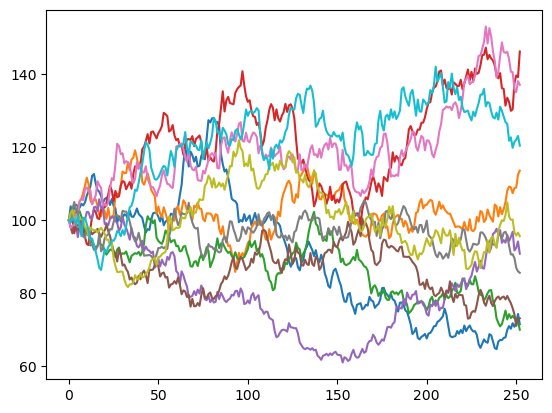

In [21]:
plt.plot(S.T);

a) Calculate the mean and the standard deviation of these 10 000 present values and present these values in a
table

b) Plot the distribution of the present values, for each strategy, using a histogram (all in the same plot)

Discussion: What effect does the rebalancing frequency have?

## 2. Delta and vega for an Asian call

Let S(0) = 100, K ∈ {80, 100, 120}, r = 0.03 and 𝜎 = 20% and 0 = $𝑡_0 < 𝑡_1 < ⋯ < 𝑡_𝑚 = 1$ where $𝑡_𝑖 − 𝑡_{𝑖−1} = \dfrac{1}{𝑚}$ for 𝑚 ∈
{12, 52}. Using 20 000 simulations,



a) Estimate delta and vega using finite differences (both f.d. and c.d.) with h = 1 for delta and h = 0.01 for vega


Method:

Delta

- To calculate the forward and center difference the following steps were performed

    - Stock price trajectories were simulated along with copies of the trajectories shifted up and down by an amount h = 1
    - The payoffs were calculated for all three of the matrices containing trajectories
    - The mean of the payoffs was calculated for the payoff belinging to each matrix
    - For the forward difference the finite difference between the original stock trajectories and the upshifted trajectories were calculated. 
    - For the center difference the finite difference between the upshifted stock trajectories and the downshifted trajectories were calculated. 

Vega 
- To calculate the forward and center difference the following steps were performed

    - Three matrices with stock price trajectories were simulated as GBM:s where one had volatility 20% and the others had volatility 20% +/- h, where h = 0.01
    - The payoffs were calculated for all three of the matrices containing trajectories
    - The mean of the payoffs was calculated for the payoff belinging to each matrix
    - For the forward difference the finite difference between the original stock trajectories and the upshifted trajectories were calculated
    - For the center difference the finite difference between the upshifted stock trajectories and the downshifted trajectories were calculated 
    

In [2]:
def StockTrajectory(n_paths, n_years, timesteps, S_0, Z,r,sigma):
  dt = n_years/timesteps
  S = S_0 * np.ones((int(n_paths),n_years * timesteps +1))
  for n in range(int(n_paths)):
    for t in range(1,Z.shape[1]):
      S[n, t] = S[n,t-1] * np.exp((r-0.5 * sigma ** 2) * dt + np.sqrt(dt) * sigma * Z[n,t])
  return S


def AsianAritmetricPayoff(S,K,n_years,r):
  simulations = S.shape[0] # Number of rows
  row_length = S.shape[1]  # Row length
  payoff = np.zeros((simulations,len(K)))
  S_temp = S[:,1:]
  for index, k in enumerate(K):
    S_sum = np.sum(S_temp, axis = 1) # Rowise sum of the prices
    payoff[:,index] =  np.exp(-r*n_years) * np.maximum((S_sum/(row_length-1)) - k, 0) # Payoff calculation
  return payoff

In [7]:
#### Delta
S_0 =100 ;K =  np.array([80,100,120]);r = 0.03; sigma = 0.2; m = np.array([12,52])
n_paths = 20000; h_delta = 1; h_vega = 0.01; T = 1
print('Delta')
for m_i in m:
    #### Generating stock trajectories
    Z = np.random.standard_normal((int(n_paths),T * m_i +1))
    S = StockTrajectory(n_paths,T,m_i,S_0,Z,r,sigma) 
    S_FrontShift =StockTrajectory(n_paths,T,m_i,S_0+h_delta,Z,r,sigma)   #S + h_delta
    S_BackShift = StockTrajectory(n_paths,T,m_i,S_0- h_delta,Z,r,sigma)   #S - h_delta
    

    #### Calculating payoffs
    Y_hat = np.mean(AsianAritmetricPayoff(S,K,T,r),axis=0)
    Y_hat_F = np.mean(AsianAritmetricPayoff(S_FrontShift,K,T,r),axis=0)
    Y_hat_B = np.mean(AsianAritmetricPayoff(S_BackShift,K,T,r),axis=0)

    #### Calculating deltas
    DeltaF = (Y_hat_F-Y_hat)/h_delta
    DeltaC= (Y_hat_F-Y_hat_B)/(2*h_delta)

    print(f'm={m_i}')
    print('Forward',DeltaF)
    print('Center',DeltaC)



Delta
m=12
Forward [0.94560369 0.52520789 0.08493845]
Center [0.94255872 0.51019671 0.07946586]
m=52
Forward [0.95111955 0.52371488 0.07523685]
Center [0.94846851 0.50747235 0.07078738]


In [39]:
#### Vega
S_0 =100 ;K =  np.array([80,100,120]);r = 0.03; sigma = 0.2; m = np.array([12,52])
n_paths = 20000;  h_vega = 0.01; T = 1
print('Vega')
for m_i in m:
    #### Generating stock trajectories
    Z = np.random.standard_normal((int(n_paths),T * m_i +1))
    S = StockTrajectory(n_paths,T,m_i,S_0,Z,r,sigma) 
    S_FrontShift = StockTrajectory(n_paths,T,m_i,S_0,Z,r,sigma+h_vega) 
    S_BackShift = StockTrajectory(n_paths,T,m_i,S_0,Z,r,sigma-h_vega) 
    
    #### Calculating payoffs
    Y_hat = np.mean(AsianAritmetricPayoff(S,K,T,r),axis=0)
    Y_hat_F = np.mean(AsianAritmetricPayoff(S_FrontShift,K,T,r),axis=0)
    Y_hat_B = np.mean(AsianAritmetricPayoff(S_BackShift,K,T,r),axis=0)

    #### Calculating deltas
    VegaF = (Y_hat_F-Y_hat)/h_vega
    VegaC= (Y_hat_F-Y_hat_B)/(2*h_vega)

    print(f'm={m_i}')
    print('Forward',VegaF)
    print('Center',VegaC)


Vega
m=12
Forward [ 3.56018324 23.92946484 11.58349149]
Center [ 3.25922574 23.92325363 11.1032226 ]
m=52
Forward [ 2.25817311 22.43959768  9.65362063]
Center [ 2.00066362 22.43630747  9.19650655]


b) Estimate delta and vega using pathwise derivatives


Method:

Delta
- Using averages of simulated stock path trajectories an estimate for the delta was calculated as described in lecture 12.

Vega
- The estimate of vega was calculated as described in exaple 7.2.3 about the path dependent vega in the course book. 

In [115]:
def AsianPath(S,K,n_years,r):
  simulations = S.shape[0] # Number of rows
  row_length = S.shape[1]  # Row length
  payoff = np.zeros((simulations,len(K)))
  S_temp = S[:,1:]
  for index, k in enumerate(K):
    S_sum = np.sum(S_temp, axis = 1) # Rowise sum of the prices
    payoff[:,index] =  np.exp(-r*n_years) * np.maximum((S_sum/(row_length-1)) - k, 0) # Payoff calculation
  return 

def AboveStrike(S_bars,K):
  Above_Strike = np.zeros((n_paths,len(K)))
  for i in range(len(S_bars)):
      for k_i, k in enumerate(K):
          if S_bars[i,k_i] > k:
              Above_Strike[i,k_i] = 1
  return Above_Strike

In [119]:
#### Delta
S_0 =100 ;K =  np.array([80,100,120]);r = 0.03; sigma = 0.2; m = np.array([12,52])
n_paths = 20000; h_delta = 1; T = 1
print(f'Delta for strikes    K={K[0]}       K={K[1]}      K={K[2]}')
for m_i in m:
    #### Generating stock trajectories
    Z = np.random.standard_normal((int(n_paths),T * m_i +1))
    S = StockTrajectory(n_paths,T,m_i,S_0,Z,r,sigma) 
    
    S_bars = np.mean(S[:,1:],axis = 1)
    S_bars_repeated = np.tile(S_bars.reshape(-1, 1), (1, len(K)))

    Above_Strike = AboveStrike(S_bars_repeated,K)

    InMean = np.exp(-r*T) * Above_Strike * (S_bars_repeated /S_0)

    Delta = np.mean(InMean, axis = 0)
    print(f'Delta for m = {m_i} is {Delta}')
 



Delta for strikes    K=80       K=100      K=120
Delta for m = 12 is [0.9653071  0.55908642 0.10044861]
Delta for m = 52 is [0.96679223 0.55427036 0.08414059]


In [102]:
def AboveStrike(S_bars,K):
  Above_Strike = np.zeros((n_paths,len(K)))
  for i in range(len(S_bars)):
      for k_i, k in enumerate(K):
          if S_bars[i] > k:
              Above_Strike[i,k_i] = 1
  return Above_Strike

In [113]:
#### Vega
S_0 =100 ;K =  np.array([80,100,120]);r = 0.03; sigma = 0.2; m = np.array([12,52])
n_paths = 20000 ; T = 1
print(f'Vega for strikes      K={K[0]}       K={K[1]}        K={K[2]}')
for m_i in m:
    #### Generating stock trajectories
    Z = np.random.standard_normal((int(n_paths),T * m_i +1))
    S = StockTrajectory(n_paths,T,m_i,S_0,Z,r,sigma) 
    S_bars = np.mean(S[:,1:],axis = 1)

    t_mat = np.linspace(0,T,m_i*1 +1)
    t_matrix = np.tile(t_mat ,( n_paths,1))
        
    dSdSigma = S *(np.log(S/S_0) - ( r+1/2*sigma ** 2) * t_matrix)/sigma
    
    Above_Strike = AboveStrike(S_bars,K)
    
    VegaM = np.zeros((n_paths,m_i))

    vegas = np.zeros((len(K)))
    for k in range(len(K)):
        vega = np.exp(-r*T) * np.mean(dSdSigma,axis = 1) * Above_Strike[:,k]
        vegas[k] = np.mean(vega)

    print(f' Vega for m = {m_i} is {vegas}')


Vega for strikes      K=80       K=100        K=120
 Vega for m = 12 is [ 2.80652889 22.26276229 10.45634237]
 Vega for m = 52 is [ 2.03715971 21.9224645   9.27179923]


Discussion: Are these vegas higher/lower than regular call vegas? Why is that?



## 3. Estimation of gamma using LRM and QMC

With S0, K, r, T and σ as above, estimate gamma for a regular call option using (in a and b only for K=100):

a) LRM and plot the estimated gammas when using 10 000, ..., 100 000 simulations (include the exact value)

b) by combining LRM with QMC and plot the estimated gammas when using 10 000, ..., 100 000 simulations

c) Produce a table of gamma values for the two methods and all strikes using 20 000 simulations.

Discussion: How do these methods compare?

## 4. Implied volatilities and greeks for American options

The files “TSLA_calls.csv” and “TSLA_puts.csv” contain prices of options1, on Tesla, maturing in 2024-09-20. These option
prices were extracted on 2024-03-15 when the stock price, S(0), was 165.8. With r = 5%:

a) What would it cost to buy a long strangle with strikes 135 and 195?

Method: 
- The long strangle is buying both the call and the put at the same strike. So the price of the strangle is calculated by summing the prices of the call and the put at each of the strikes. The ask price is used because to be sure to get to buy it the bid ask spread must be paid.  

In [91]:
S_0 =165.8; r = 0.05; K = np.array([135,195])

TSLA_Calls = pd.read_csv('TSLA_calls.csv',delimiter = ';')
TSLA_Puts = pd.read_csv('TSLA_puts.csv',delimiter = ';')

callprice = TSLA_Calls[TSLA_Calls['Strike'] == K[1]]['Ask'].values[0]
putprice = TSLA_Puts[TSLA_Puts['Strike'] == K[0]]['Ask'].values[0]

LongStrangle = callprice +putprice 
print(f'The price of the long strangle at  is: {LongStrangle:.3f}')


The price of the long strangle at  is: 23.400


b) Based on the put option prices, calculate the implied volatilities for strikes 100 - 230 and present them in a line
plot and a table. Use the average of Bid and Ask as the market price and calculate the implied volatilities by
“inverting” the binomial tree, with a weekly time step.

Method: 
- For each of the strikes the bisection algorithm was used to find the value of sigma that made the price from the binomial model match the price on the market.

In [14]:
def BinomialPrice(S_0, T,m, K, sigma,r):
  m_Maturity = round(T*m)
  dt = 1/m
  S = np.zeros((int(m_Maturity+1),int(m_Maturity+1)))
  S[0,0] = S_0
  u = np.exp(sigma* np.sqrt(dt))
  d = np.exp(-sigma* np.sqrt(dt))

  ### Generate Binomial tree
  for i in range(0,m_Maturity+1):
    for j in range(1,m_Maturity+1):
      if i <= j:
        S[i,j] = S_0 * (d ** i) * (u ** (j-i))

  ### Generate exercise value matrix
  ExerciseValue = np.zeros((m_Maturity+1,m_Maturity+1))
  for i in range(0,m_Maturity+1):
    for j in range(0,m_Maturity+1):
      if i <= j:
        ExerciseValue[i,j] = np.maximum(K-S[i,j],0)

  #print(ExerciseValue)
  ### Changing exercise value matrix to get 
  ContinuationValue = np.zeros((m_Maturity+1,m_Maturity+1))
  p = (np.exp(r*dt)-d)/(u-d)
  q = 1-p

  for j in range(m_Maturity-1,-1,-1):
    for i in range(0,m_Maturity):
      ContVal= np.exp(-r*dt) *( p * ExerciseValue[i,j+1] + (1-p) * ExerciseValue[i+1,j+1])      
      if i <= j and ExerciseValue[i,j] < ContVal :
        ExerciseValue[i,j] = ContVal
  return ExerciseValue[0,0] #,ContinuationValue

def BisectionAlg(Price, tolerance,S,r,K,T,m, upper = 1, lower=0):
  midpoint = (upper + lower)/2
  Binomial_Price = BinomialPrice(S,T,m,K,midpoint,r)

  
  iterations =0
  while np.abs(Price - Binomial_Price) > tolerance and iterations <10000:
    midpoint = (upper + lower)/2
    Binomial_Price = BinomialPrice(S,T,m,K,midpoint,r)
    
    if Price > Binomial_Price:
      lower = midpoint
    else:
      upper = midpoint
    iterations = iterations +1
  return midpoint



,Strike,Implied Volatility
0,100.0,0.566
1,105.0,0.555
2,110.0,0.545
3,115.0,0.543
4,120.0,0.529
5,125.0,0.516
6,130.0,0.514
7,135.0,0.509
8,140.0,0.501
9,145.0,0.486


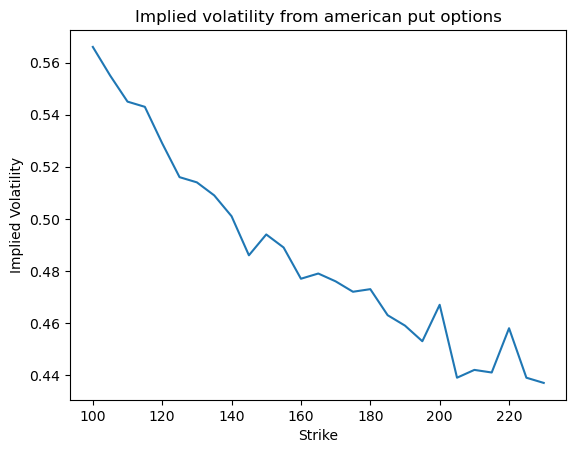

In [15]:
S_0 =165.8; r = 0.05; K = np.arange(100,235,5)
m = 52
t = '2024-03-15'
T = '2024-09-20'
date_t = datetime.strptime(t, '%Y-%m-%d')
date_T = datetime.strptime(T, '%Y-%m-%d')

difference =  date_T- date_t
difference_in_days = difference.days
Maturity = difference_in_days/365

TSLA_Puts = pd.read_csv('TSLA_puts.csv',delimiter = ';')
### Add column with average prices
TSLA_Puts['Price'] = (TSLA_Puts['Ask']+TSLA_Puts['Bid'])/2

res = np.zeros((len(K),2))

for k_i,k in enumerate(K):
    putprice = TSLA_Puts[TSLA_Puts['Strike'] == k]['Price'].iloc[0]

    IV = BisectionAlg(putprice,0.000001,S_0, r,k,Maturity,m,1,0.01)
    res[k_i,0] = k
    res[k_i,1] = round(IV,3)
    #print(f'The implied volatility for k={k} is {IV:.3f}')


plt.plot(res[:,0],res[:,1]);
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title('Implied volatility from american put options');

df = pd.DataFrame(res, columns = ['Strike','Implied Volatility'])
df



In [104]:
df2 = df
res2 = np.zeros(len(K))
for k_i, k in enumerate(K):
    #print(BinomialPrice(S_0,Maturity,m,k,res[k_i,1],r))
    res2[k_i] = BinomialPrice(S_0,Maturity,m,k,res[k_i,1],r)




c) For K = 165, estimate theta (daily), delta and gamma from the binomial tree at t = 0

Method:
- Theta
    - For theta the estimate was calculated by taking the difference between the option price in time 0 and in time step 2 when the stock price had gone up and down. This difference was then divided by the length of the two time steps, i.e. 2 weeks. 

- Delta
    - For delta the estimate was calculated by taking the difference between the option prices in the up and down scenario in the first time step and then dividing by the difference in stock price between the up and down scenario. 

- Gamma
    - For the gamma two deltas were calculated at time step 1. Two average stock prices were also calculated from time step 2 between the up and middle node and between the middle and down node respectively. The finite difference was then calculated with the difference between the deltas in the nominator and the difference between the stockprices in the denominator.

In [75]:
def BinomialPrice(S_0, T,m, K, sigma,r):
  m_Maturity = int(T*m)
  dt = 1/m
  S = np.zeros((int(m_Maturity+1),int(m_Maturity+1)))
  S[0,0] = S_0
  u = np.exp(sigma* np.sqrt(dt))
  d = np.exp(-sigma* np.sqrt(dt))

  ### Generate Binomial tree
  for i in range(0,m_Maturity+1):
    for j in range(1,m_Maturity+1):
      if i <= j:
        S[i,j] = S_0 * (d ** i) * (u ** (j-i))

  ### Generate exercise value matrix
  ExerciseValue = np.zeros((m_Maturity+1,m_Maturity+1))
  for i in range(0,m_Maturity+1):
    for j in range(0,m_Maturity+1):
      if i <= j:
        ExerciseValue[i,j] = np.maximum(K-S[i,j],0)

  #print(ExerciseValue)
  ### Changing exercise value matrix to get 
  ContinuationValue = np.zeros((m_Maturity+1,m_Maturity+1))
  p = (np.exp(r*dt)-d)/(u-d)
  q = 1-p

  for j in range(m_Maturity-1,-1,-1):
    for i in range(0,m_Maturity):
      ContVal= np.exp(-r*dt) *( p * ExerciseValue[i,j+1] + (1-p) * ExerciseValue[i+1,j+1])      
      if i <= j and ExerciseValue[i,j] < ContVal :
        ExerciseValue[i,j] = ContVal
  return ExerciseValue, S #,ContinuationValue

In [76]:
K = 165; S_0 =165.8; r = 0.05 

sigma = res[13,1] # from part b

m = 52
dt = 1/m
t = '2024-03-15'
T = '2024-09-20'
date_t = datetime.strptime(t, '%Y-%m-%d')
date_T = datetime.strptime(T, '%Y-%m-%d')

difference =  date_T- date_t
difference_in_days = difference.days
Maturity = difference_in_days/365

TSLA_Puts = pd.read_csv('TSLA_puts.csv',delimiter = ';')
### Add column with average prices
TSLA_Puts['Price'] = (TSLA_Puts['Ask']+TSLA_Puts['Bid'])/2


Pricepaths , Stockpaths= BinomialPrice(S_0, Maturity,m, K, sigma,r)
### Calculating theta
DailyTheta = (Pricepaths[1,2]-Pricepaths[0,0] )/(2*dt)/m

### Calculating delta
Delta = (Pricepaths[0,1]-Pricepaths[1,1])/(Stockpaths[0,1]-Stockpaths[1,1])

### Calculating gamma
delta1 = (Pricepaths[0,2]-Pricepaths[1,2])/(Stockpaths[0,2]-Stockpaths[1,2])
delta2 = (Pricepaths[1,2]-Pricepaths[2,2])/(Stockpaths[1,2]-Stockpaths[2,2])
s1 = (Stockpaths[0,2]-Stockpaths[1,2])/2
s2 = (Stockpaths[1,2]-Stockpaths[2,2])/2

gamma = (delta1-delta2)/(s1-s2)

print(f'Theta: {DailyTheta:.3f}')
print(f'Delta: {Delta:.3f}')
print(f'Gamma: {gamma:.3f}')

Theta: -0.376
Delta: -0.409
Gamma: 0.104


Discussion: What is the shape of the plot in b (a smile or a skew)?

## 5. American basket put option on two underlying stocks

We assume that the option is a Bermudan option that can only be exercised at $𝑡_𝑖 = 𝑖 * \dfrac{𝑇}{6}$ for 𝑖 ∈ {1, ... ,6}, where T = 1.

Let the underlying stock prices be 100, the volatilities 30% and r = 3%. Use the least squares MC-method with 40 000
simulated paths to

a) Price the option for all combinations of correlations: 𝜌 ∈ {0, 0.5}, and strikes: 𝐾 ∈ {80, 100, 120}

b) Calculate the early exercise premiums (use your implementation from assignment 1 of the European basket put
option but now with 40 000 simulations)